Imports, simple plotting function

In [1]:
from rhocube import *
from models import *
import pylab as p
import matplotlib
%matplotlib inline

def myplot(images,titles='',interpolation='bicubic'):
    if not isinstance(images,list):
        images = [images]
    n = len(images)
    if not isinstance(titles,list):
       titles = [titles] 
    assert (len(titles)==n)
    fig = p.figure(figsize=((2.5+0.4)*n,2.5))
    for j,image in enumerate(images):
        ax = fig.add_subplot(1,n,j+1)
        im = ax.imshow(image,origin='lower',extent=[-1,1,-1,1],cmap=matplotlib.cm.Blues_r,interpolation=interpolation)
        if titles is not None:
            ax.set_title(titles[j],fontsize=9)

# Cube class
All models, whether provided with rhocube or own, inherit basic functionality from the `Cube` class. The class provides a `npix`^3 cube of voxels, their 3D coordinate arrays `X,Y,Z`, and several *methods for constructing* the density field $\rho(x,y,z)$. It also provides methods for *shifting* the model in $x$ and $y$ directions, and, for models where this is appropriate, for *rotating* the model about some of the principal axes.

# Available models
Several common geometrical models for the density distribution come with `rhocube`. Below we demonstrate how to instantiate and to use them. Further down we will show how `rhocube` can be easily extended with own models.

## PowerLawShell
The PowerLawShell model is spherically symmetric, has an inner and outer radius, and the density falls off in radial direction as $1/r^{\rm exponent}$. Let's instantiate a constant-density shell model with inner radius = 0.5, outer radius = 0.6, in a 101^2 pixel image (=101^3 cube of computed voxels).

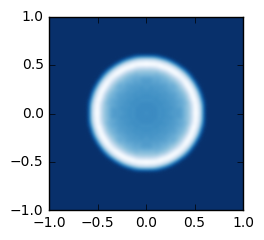

In [2]:
model = PowerLawShell(101,exponent=0.)   # npix, radial exponent in 1/r^exponent (0 = constant-density shell)
args = (0.5,0.6,0,0,None)  # rin, rout, xoff, yoff, weight
model(*args)  # call the model instance with these parameter values
myplot(model.image)  # the computed rho(x,y,z) in in model.rho; the z-integrated rho_surface(x,y) is in model.image

The shell model can also be **shifted** in the $x$ and $y$ directions on the image. The $x$-axis points right, the $y$-axis points up.

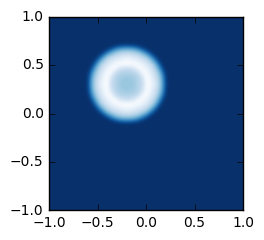

In [3]:
args = (0.2,0.4,-0.2,0.3,None) # same model instance, but different parameter values, and shifted left and up
model(*args)
myplot(model.image)

Let's plot shells with different radial powers.

models.py:176: RuntimeWarning: divide by zero encountered in reciprocal
  self.rho = self.R**self.exponent
models.py:176: RuntimeWarning: divide by zero encountered in power
  self.rho = self.R**self.exponent


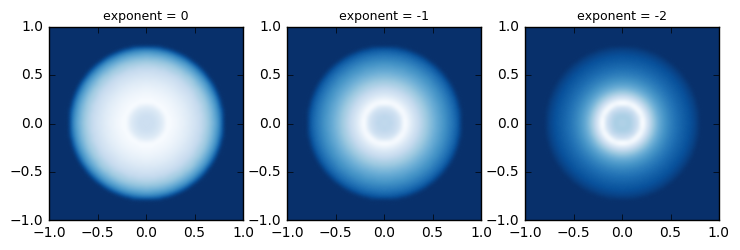

In [4]:
#fig = p.figure(figsize=(10,3))
args = (0.2,0.8,0,0,None)
powers = (0,-1,-2)   # the exponents in 1/r^exponent
images, titles = [], []
for j,pow in enumerate(powers):
    mod = PowerLawShell(101,exponent=pow)
    mod(*args)
    images.append(mod.image)
    titles.append("exponent = %d" % pow)
    
myplot(images,titles)

## TruncatedNormalShell
Another model is a Gaussian ("Normal") shell with radius `r`, width `sigma` around `r`, and lower & upper clip radii `rlo` and `rup`.

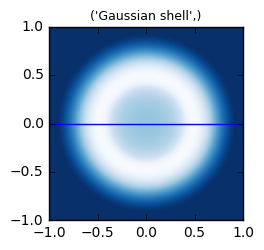

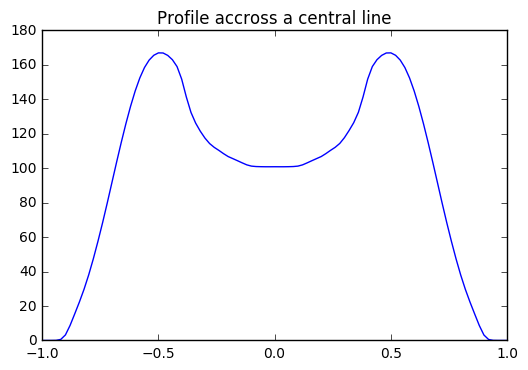

In [5]:
model = TruncatedNormalShell(101)
args = (0.6,0.15,0.4,0.9,0,0,None)  # r, sigma, rlo, rup, xoff, yoff, weight
model(*args)
myplot(model.image,("Gaussian shell",))
p.axhline(0)  # indicate profile line
fig2 = p.figure()
p.plot(N.linspace(-1,1,model.npix),model.image[model.npix/2,:]) # plot the profile accross the image
p.title("Profile accross a central line")

## Constant-density torus
The torus model has a torus radius and a tube radius, can be offset in $x$ and $y$, and can be **tilted** about the $x$-axis (points right) and $z$-axis (points to the observer). The tilts are given in degrees.

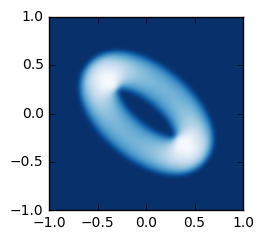

In [6]:
model = ConstantDensityTorus(101)
args = (0.6,0.2,0,0,30,40,None) # radius, tube radius, xoff, yoff, tiltx, tiltz, weight
model(*args)
myplot(model.image)

## Constant-density dual cone
The dual cone model has a height (from center) and a opening angle theta (in degrees). Like the torus, the dual cone can be tilted about the $x$ and $z$ axes, and shifted in $x$ and $y$.

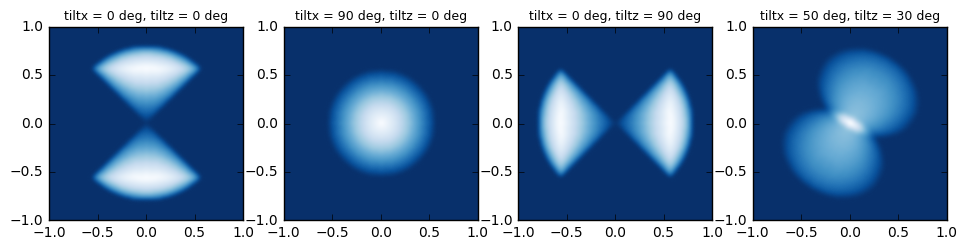

In [7]:
model = ConstantDensityDualCone(101)
tilts = ([0,0],[90,0],[0,90],[50,30])  # about [x,z] axes
args = [[0.8,45]+tilts_+[0,0,None] for tilts_ in tilts] # height,theta,tiltx,tiltz,xoff,yoff,weight
images, titles = [],[]
for j,args_ in enumerate(args):
    model(*args_)
    images.append(model.image)
    titles.append('tiltx = %d deg, tiltz = %d deg' % tuple(args[j][2:4]))
myplot(images,titles)

## Helix3D
The density fields computed by `rhocube` need not be spherically or axially symmetric. A model provided with `rhocube` is a 3D helical tube, i.e. a parametric curve with a given tube cross-section radius. Let's define a helix that spirals outwards **along the surface of a dual cone**:

Building kdtree


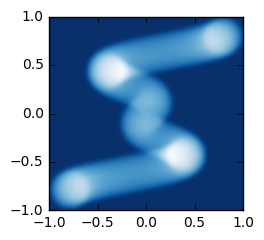

In [8]:
model = Helix3D(101,envelope='dualcone')
args = (0.8,1,0.2,0,0,0,0,0,None) # height from center (= radius at top), number of turns, tube cross-section radius, x/y/z tilts, x/y offsets, weight
model(*args)
myplot(model.image)

**Caution:** This class of models internally computes a **k-d tree** to speed up subsequent computations of the density field. Note that the **k-d tree construction time is an expensive function** of `npix`. The subsequent computations are then much faster. In other words: you might not have the patience to wait for a 301^3 voxel tree to be constructed.

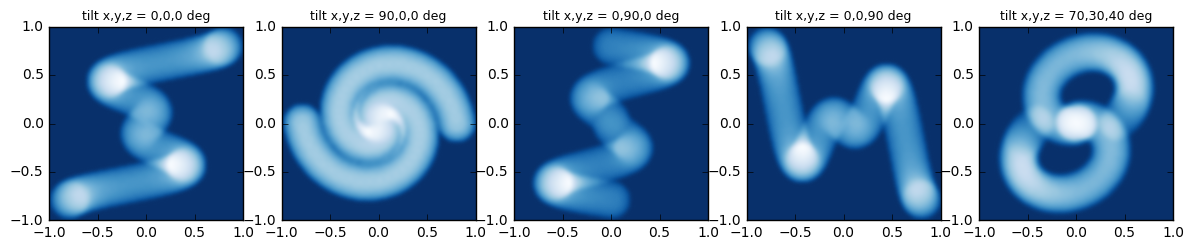

In [9]:
tilts = ([0,0,0],[90,0,0],[0,90,0],[0,0,90],[70,30,40])  # tilt angles about the [x,y,z] axes
args = [[0.8,1,0.2]+tilts_+[0,0,None] for tilts_ in tilts] # height, nturns, tube radius, x/y/z tilts, x/y offsets, weight
images, titles = [],[]
for j,args_ in enumerate(args):
    model(*args_)
    images.append(model.image) 
    titles.append('tilt x,y,z = %d,%d,%d deg' % (args[j][3],args[j][4],args[j][5]))
myplot(images,titles)

The plot above shows the same helix rotated in 3D to five different points of view.

The helix can also spiral along the surface of a **cylinder**:

Building kdtree


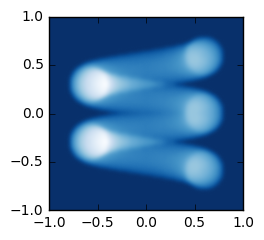

In [10]:
model = Helix3D(101,envelope='cylinder')
args = (0.6,1,0.2,0,0,0,0,0,None) # height, nturns, tube cross-section radius, 3 tilts, 2 offsets, weight
model(*args)
myplot(model.image)

# Adding custom model classes
Custom models can be very easily added to `rhocube`. Just write a small Python class. Below we show in a simple example how one can construct a custom 3D density model that computes a spherically symmetric $\rho(R)$ which varies as the cosine of distance, i.e. $\rho(R)\propto\cos(R)$.

In [11]:
class CosineShell(Cube):
    def __init__(self,npix):
        Cube.__init__(self,npix,computeR=True)  # 'computeR' is a built-in facility, and by default True; check out also 'buildkdtree'
    def __call__(self):
        self.get_rho()
    def get_rho(self):
        self.rho = N.cos(self.R*N.pi)
        self.apply_rho_ops() # shift, rotate3d, smoothing

You can then use it simply like this:

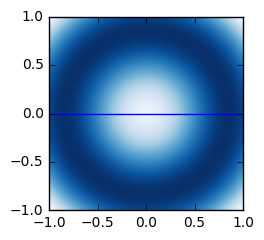

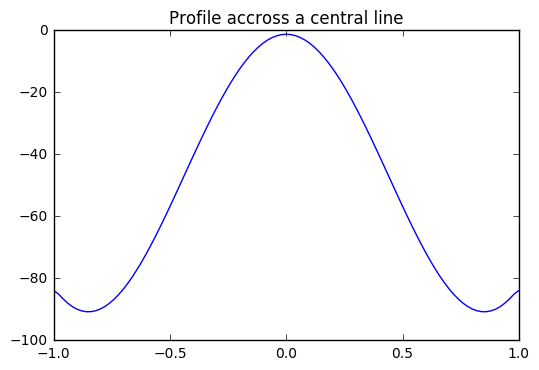

In [12]:
model = CosineShell(101) # 101 pixels along each cube axis
model() # this model has no free parameters
myplot(model.image)
p.axhline(0)  # indicate profile line
fig2 = p.figure()
p.plot(N.linspace(-1,1,model.npix),model.image[model.npix/2,:]) # plot the profile accross the image
p.title("Profile accross a central line")

# Special functions

## *transform* class
An optional `transform` function $f(\rho)$ can be passed as an argument when creating a model instance. Transform functions are implemented as simple Python classes. The transform will be applied to the density field before $z$-integration, i.e. $\int dz\ f(\rho(x,y,z))$ will be computed. For instance, squaring of density field $\rho(x,y,z)$ before integration can be achived via:

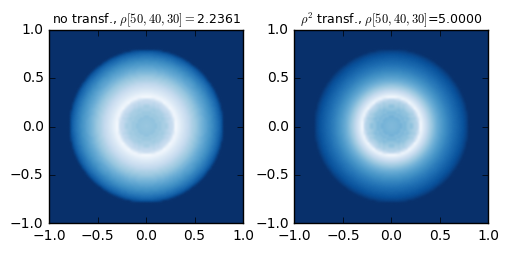

In [13]:
model1 = PowerLawShell(101,exponent=-1.,smoothing=None)  # no transform of rho(x,y,z)
model2 = PowerLawShell(101,exponent=-1.,smoothing=None,transform=PowerTransform(2.)) # i.e. rho^2(x,y,z) will be computed
args = (0.3,0.8,0,0,None) # rin, rout, xoff, yoff, weight
model1(*args)
model2(*args)
myplot([model1.image,model2.image],\
       [r'no transf., $\rho[50,40,30]=$%.4f' % model1.rho[50,40,30],\
        r'$\rho^2$ transf., $\rho[50,40,30]$=%.4f' % model2.rho[50,40,30]])

Note how the $\rho$ value of voxel [50,40,30] (as an example) on the right is exactly the squared value of the model on the left.

### inverse function
If the supplied $f(\rho)$ class also provides an inverse function `_inverse`, e.g. $f^{-1} = \sqrt{\cdot}$ when $f = (\cdot)^2$, then from a scaled _image_ the entire cube of $\rho(x,y,z)$ voxels can be computed with correct scaling. This is very useful if the application of `rhocube` is to model the $z$-integrated **image** of some observations for instance, but the 3D density distribution is not known. For example:

In [14]:
# make a model with density transforming as rho-->rho^2
model = PowerLawShell(101,exponent=-1,transform=PowerTransform(2.))
args = (0.3,0.8,0,0,None)
model(*args)
print "transform and _inverse functions of the model:"
print model.transform
print model.transform._inverse

transform and _inverse functions of the model:
<rhocube.PowerTransform instance at 0x7f6a89836878>
<bound method PowerTransform._inverse of <rhocube.PowerTransform instance at 0x7f6a89836878>>


Now imagine that fitting the map to a data map told you that you must scale your **2D model image** by a factor `scale` to match the **2D data image**... By how much should you multiply the underlying **3D density field $\rho(x,y,z)$** in order to achieve the desired scaling?

In [15]:
scale = 16.  # this is the image scaling factor you got from fitting...
# ... and since the model knows the _inverse transform function, it can compute the required scaling of rho(x,y,z)
print "Image scale = %.3f requires rho to be scaled by %.5f" % (scale,model.transform._inverse(scale))

Image scale = 16.000 requires rho to be scaled by 4.00000


Let's try the same model but with a different transform

In [16]:
model = PowerLawShell(101,exponent=-1,transform=PowerTransform(3.))
args = (0.3,0.8,0,0,None)
model(*args)
scale = 16.  # this is the image scaling factor you got from fitting...
print "Image scale = %.3f requires rho to be scaled by %.5f" % (scale,model.transform._inverse(scale))

Image scale = 16.000 requires rho to be scaled by 2.51984


Several common transform classes are provided with `rhocube`, e.g. `PowerTransform`, which we used above, or `LogTransform` which computes a `base`-base logarithm of $\rho(x,y,z)$. Another provided transform is `GenericTransform` which can take any parameter-free `numpy` function and an inverse functon (the defaults are `func=’sin’` and `inversefunc=’arcsin’`). Custom transform functions can be easily added.

## Smoothing of the 3D density field
Upon instantiating a model, the `smoothing` parameter can be specified. If smoothing is a float value, it is the width (in standard deviations) of a 3D Gaussian kernel that $rho(x,y,z)$ will be convolved with, resulting in a smoothed 3D density distribution. Smoothing does preserve the total $\sum_i (x,y,z)$, where $i$ runs over all voxels, but need not preserve $\rho$ with a single voxel. `smoothing=1.0` is the default, and does not alter the resulting structure significantly. If `smoothing=None`, no smoothing will be performed.

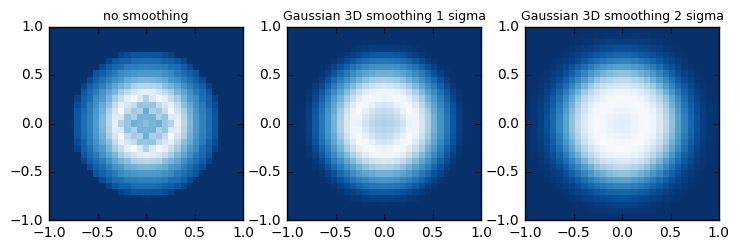

In [17]:
model0 = PowerLawShell(31,exponent=-2,smoothing=None) # no smoothing
model1 = PowerLawShell(31,exponent=-2,smoothing=1.0)  # Gaussian 3D kernel smoothing, width=1sigma
model2 = PowerLawShell(31,exponent=-2,smoothing=2.0)  # Gaussian 3D kernel smoothing, width=2sigma
args = (0.3,0.8,0,0,None)
model0(*args)
model1(*args)
model2(*args)
myplot([model0.image,model1.image,model2.image],\
       ['no smoothing','Gaussian 3D smoothing 1 sigma','Gaussian 3D smoothing 2 sigma'],interpolation='none')

In [18]:
print "Sum over all voxels\nwithout smoothing: %.2f\nwith smoothing=1.0: %.2f\nwith smoothing=2.0: %.2f" % (model0.rho.sum(), model1.rho.sum(), model2.rho.sum())

Sum over all voxels
without smoothing: 20994.67
with smoothing=1.0: 20994.67
with smoothing=2.0: 20994.67


Smoothing indeed preserves the total mass.

## The `weight` parameter
When calling a model instance with parameter values, a `weight` argument can be given. If `weight=None` (the default), `rho(x,y,z)` will be computed by the model function as-is. If `weight` is a floating-point number, then the $\rho(x,y,z)$ cube will be normalized such that the sum of all voxels equals `weight`. Any `transform` function (if given) will be applied to $\rho(x,y,z)$ **before** normalizing to `weight`. Examples:

In [19]:
def myprint(t,model):
    print "%s, weight = %r --> model.rho.sum() = %.1f" % (t,model.weight,model.rho.sum())

model = PowerLawShell(101,exponent=-1)
model(*(0.3,0.8,0,0,None))
myprint("No transform",model)
model(*(0.3,0.8,0,0,0.8))
myprint("No transform",model)

model = PowerLawShell(101,exponent=-1,transform=PowerTransform(2.))
model(*(0.3,0.8,0,0,None))
myprint("PowerTransform(2)",model)
model(*(0.3,0.8,0,0,0.8))
myprint("PowerTransform(2)",model)

No transform, weight = None --> model.rho.sum() = 432034.8
No transform, weight = 0.8 --> model.rho.sum() = 0.8
PowerTransform(2), weight = None --> model.rho.sum() = 786456.7
PowerTransform(2), weight = 0.8 --> model.rho.sum() = 0.8
